In [1]:
from copy import deepcopy
from typing import Literal, Optional

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

# Setup

In [2]:
QWERTY_LOW_LAYOUT: list[list[str]] = [
    ["`", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "-", "=", "<back>"],
    ["<tab>", "q", "w", "e", "r", "t", "y", "u", "i", "o", "p", "[", "]", "\\"],
    [
        "<caps>",
        "a",
        "s",
        "d",
        "f",
        "g",
        "h",
        "j",
        "k",
        "l",
        ";",
        "'",
        "<enter>",
        "<enter>",
    ],
    [
        "<shift>",
        "<shift>",
        "z",
        "x",
        "c",
        "v",
        "b",
        "n",
        "m",
        ",",
        ".",
        "/",
        "<shift>",
        "<shift>",
    ],
    [
        "<ctrl>",
        "<alt>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<alt>",
        "<ctrl>",
    ],
]

QWERTY_HIGH_LAYOUT: list[list[str]] = [
    ["~", "!", "@", "#", "$", "%", "^", "&", "*", "(", ")", "_", "+", "<back>"],
    ["<tab>", "Q", "W", "E", "R", "T", "Y", "U", "I", "O", "P", "{", "}", "|"],
    [
        "<caps>",
        "A",
        "S",
        "D",
        "F",
        "G",
        "H",
        "J",
        "K",
        "L",
        ":",
        '"',
        "<enter>",
        "<enter>",
    ],
    [
        "<shift>",
        "<shift>",
        "Z",
        "X",
        "C",
        "V",
        "B",
        "N",
        "M",
        "<",
        ">",
        "?",
        "<shift>",
        "<shift>",
    ],
    [
        "<ctrl>",
        "<alt>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<alt>",
        "<ctrl>",
    ],
]

In [3]:
(
    len(QWERTY_HIGH_LAYOUT),
    len(QWERTY_HIGH_LAYOUT[0]),
    len(QWERTY_HIGH_LAYOUT[1]),
    len(QWERTY_HIGH_LAYOUT[2]),
    len(QWERTY_HIGH_LAYOUT[3]),
    len(QWERTY_HIGH_LAYOUT[4]),
)

(5, 14, 14, 14, 14, 11)

In [4]:
def get_buttons_set(
    low_layout: list[list[str]], high_layout: list[list[str]]
) -> set[str]:
    buttons: set[str] = set()

    for layout in [low_layout, high_layout]:
        for i in range(len(layout)):
            for btn in layout[i]:
                buttons.add(btn)

    return buttons


def get_keyboard_shape(layout: list[list[str]]) -> tuple[int, ...]:
    shape = [len(row) for row in layout]

    return tuple(shape)


BUTTONS_SET = get_buttons_set(QWERTY_LOW_LAYOUT, QWERTY_HIGH_LAYOUT)
KEYBOARD_LAYOUT_SHAPE = get_keyboard_shape(QWERTY_LOW_LAYOUT)
KEYBOARD_LAYOUT_CUMSUM_SHAPE = np.cumsum(KEYBOARD_LAYOUT_SHAPE)
KEYS = sum(KEYBOARD_LAYOUT_SHAPE) * 2

In [5]:
n = 67
PAIR_TO_ID = {}
ID_TO_PAIR = {}
c = 0
for i in range(134):
    for j in range(i + 1, 134):
        PAIR_TO_ID[(i, j)] = c
        ID_TO_PAIR[c] = (i, j)
        c += 1

ACTION_SPACE_SIZE = c

In [6]:
ACTION_SPACE_SIZE

8911

In [7]:
def encode_decode_buttons(buttons: set[str]) -> tuple[dict[str, int], dict[int, str]]:
    letters_dict = {}
    for idx, letter in enumerate("abcdefghijklmnopqrstuvwxyz"):
        letters_dict[letter] = idx + 1
        # letters_dict[letter.upper()] = -(idx + 1)

    offset = len(letters_dict)
    for idx, letter in enumerate("abcdefghijklmnopqrstuvwxyz".upper()):
        letters_dict[letter] = offset + idx + 1
        # letters_dict[letter.upper()] = -(idx + 1)

    encode_value = len(letters_dict) + 1  # (len(letters_dict) // 2) + 1
    encode_dict = {}
    decode_dict = {}
    for btn in buttons:
        if btn in letters_dict:
            decode_dict[letters_dict[btn]] = btn
            encode_dict[btn] = letters_dict[btn]
        else:
            decode_dict[encode_value] = btn
            encode_dict[btn] = encode_value
            encode_value += 1
    return encode_dict, decode_dict


ENCODE_DICT, DECODE_DICT = encode_decode_buttons(BUTTONS_SET)
ENCODED_BUTTONS_SET = {ENCODE_DICT[btn] for btn in BUTTONS_SET}
SHIFT_CODE = ENCODE_DICT["<shift>"]

In [8]:
ENCODE_DICT

{'<alt>': 53,
 ':': 54,
 'V': 48,
 'o': 15,
 ',': 55,
 '8': 56,
 'l': 12,
 '0': 57,
 '@': 58,
 'r': 18,
 'q': 17,
 'B': 28,
 '1': 59,
 'M': 39,
 's': 19,
 '<space>': 60,
 'X': 50,
 'x': 24,
 'S': 45,
 'D': 30,
 '<caps>': 61,
 '-': 62,
 '<enter>': 63,
 '5': 64,
 'g': 7,
 '"': 65,
 '[': 66,
 "'": 67,
 '`': 68,
 'H': 34,
 'v': 22,
 'p': 16,
 'L': 38,
 '<ctrl>': 69,
 'T': 46,
 '#': 70,
 'w': 23,
 '4': 71,
 'Z': 52,
 '%': 72,
 'm': 13,
 'e': 5,
 '+': 73,
 '?': 74,
 'P': 42,
 'N': 40,
 '<tab>': 75,
 '>': 76,
 'A': 27,
 'j': 10,
 'n': 14,
 ')': 77,
 'F': 32,
 'K': 37,
 'a': 1,
 '.': 78,
 'Q': 43,
 'R': 44,
 ';': 79,
 ']': 80,
 'd': 4,
 '\\': 81,
 'Y': 51,
 '}': 82,
 'U': 47,
 '7': 83,
 'i': 9,
 'W': 49,
 'J': 36,
 '<back>': 84,
 'f': 6,
 'C': 29,
 '(': 85,
 '~': 86,
 'G': 33,
 '<shift>': 87,
 'c': 3,
 '$': 88,
 '^': 89,
 '&': 90,
 '!': 91,
 'k': 11,
 'u': 21,
 'E': 31,
 '*': 92,
 'I': 35,
 '9': 93,
 '3': 94,
 '2': 95,
 'y': 25,
 '<': 96,
 '6': 97,
 '=': 98,
 '_': 99,
 'b': 2,
 'O': 41,
 't': 

In [9]:
for btn in BUTTONS_SET:
    assert btn == DECODE_DICT[ENCODE_DICT[btn]]

In [10]:
len(BUTTONS_SET)

102

In [11]:
Layout = list[list[int]]


def encode_layout(layout: list[list[str]]) -> Layout:
    return [[ENCODE_DICT[btn] for btn in layout[i]] for i in range(len(layout))]


def decode_layout(layout: Layout) -> list[list[str]]:
    return [[DECODE_DICT[btn] for btn in layout[i]] for i in range(len(layout))]


QWERTY_ENCODED_HIGH: Layout = encode_layout(QWERTY_HIGH_LAYOUT)
QWERTY_ENCODED_LOW: Layout = encode_layout(QWERTY_LOW_LAYOUT)

In [12]:
def get_all_buttons_encoded(high_layout: Layout, low_layout: Layout) -> list[int]:
    all_buttons = []

    for layout in (low_layout, high_layout):
        for row in layout:
            all_buttons.extend(row)
    return all_buttons


ALL_BUTTONS_ENCODED = get_all_buttons_encoded(QWERTY_ENCODED_HIGH, QWERTY_ENCODED_LOW)

In [13]:
LogType = Literal["basic"] | Literal["debug"] | Literal["error"]


class Logger:
    def __init__(self, verbose: bool = True, hide_types: list[LogType] = []) -> None:
        self.verbose = verbose
        self.hide_types = set(hide_types)

    def log(self, message: str, log_type: LogType = "basic") -> None:
        if self.verbose and log_type not in self.hide_types:
            print(message)


LOGGER = Logger()

In [14]:
Position = tuple[int, int]


class Finger:
    def __init__(
        self, initial_position: Position, name: str, logger: Logger = LOGGER
    ) -> None:
        self.name = name
        self.initial_position = initial_position

        self.logger = logger

        self.reset()

        # Constants

        self.wait_before_return = 4  # in ticks

        self.long_row_move_shift = 3
        self.long_row_move_penalty = 1

        self.row_penalty_coefficient = 1
        self.column_penalty_coefficient = 1.2

    def reset(self):
        self.current_position = self.initial_position
        self.ticks_before_return = 0  # if == 0, returns to the initial position
        self.typed_keys = 0

    def move(self, position: Position):
        self.current_position = position

        self.ticks_before_return = self.wait_before_return
        self.typed_keys += 1

    def tick(self) -> float:
        if self.ticks_before_return > 0:
            self.ticks_before_return -= 1

        if self.ticks_before_return == 0:
            score = self.get_score(self.initial_position)
            self.current_position = self.initial_position
            return score

        return 0

    def get_score(self, target_position: Position) -> float:
        x1, y1 = self.current_position
        x2, y2 = target_position

        row_distance = abs(x1 - x2) ** 2
        column_distance = abs(y1 - y2) ** 2

        penalty = 0
        if row_distance > self.long_row_move_shift:
            penalty = self.long_row_move_penalty
        return (
            row_distance * self.row_penalty_coefficient
            + column_distance * self.column_penalty_coefficient
            + penalty
        )

    def show_statistics(self):
        self.logger.log(
            f"Name: {self.name:22} \
            Typed keys: {self.typed_keys:5} \
            Ticks before return: {self.ticks_before_return:5} \
            Current position: {self.current_position}\t\
            Default position: {self.initial_position}"
        )

In [15]:
DEFAULT_FINGERS: list[Finger] = [
    Finger((2, 1), "левый мизинец"),
    Finger((2, 2), "левый безымянный"),
    Finger((2, 3), "левый средний"),
    Finger((2, 4), "левый указательный"),
    Finger((4, 3), "левый большой"),
    Finger((4, 6), "правый большой"),
    Finger((2, 7), "правый указательный"),
    Finger((2, 8), "правый средний"),
    Finger((2, 9), "правый безымянный"),
    Finger((2, 10), "правый мизинец"),
]

SwapType = Literal["low_layout"] | Literal["high_layout"] | Literal["between_layouts"]


class KeyboardLayout:
    @staticmethod
    def layout_to_dict(
        layout: Layout, unused_layout: Layout
    ) -> dict[int, list[Position]]:
        layout_dict: dict[int, list[Position]] = {}

        for i in range(len(layout)):
            for j in range(len(layout[i])):
                button = layout[i][j]
                if button in layout_dict:
                    layout_dict[button].append((i, j))
                else:
                    layout_dict[button] = [(i, j)]

        for i in range(len(unused_layout)):
            for j in range(len(unused_layout[i])):
                button = unused_layout[i][j]
                if button not in layout_dict:
                    layout_dict[button] = []

        return layout_dict

    def _finish_move(self):
        for finger in self.fingers:
            self.total_score += finger.tick()

    def __init__(self, low_layout: Layout, high_layout: Layout, logger: Logger = LOGGER):
        self.low_layout = deepcopy(low_layout)
        self.high_layout = deepcopy(high_layout)

        self.low_layout_dict = KeyboardLayout.layout_to_dict(
            self.low_layout, self.high_layout
        )
        self.high_layout_dict = KeyboardLayout.layout_to_dict(
            self.high_layout, self.low_layout
        )

        self.logger = logger

        self.fingers = deepcopy(DEFAULT_FINGERS)

        self.reset()

    def reset(self):
        self.total_score: float = 0
        self.typed_keys: int = 0
        for f in self.fingers:
            f.reset()

    def move_one_finger(
        self, positions: list[Position], busy_finger_id: Optional[int] = None
    ) -> tuple[tuple[int, Position], float]:
        best_finger_id: int = 0
        best_score = np.inf

        final_position: Position = (0, 0)

        for position in positions:
            scores = [
                finger.get_score(position) if i != busy_finger_id else np.inf
                for i, finger in enumerate(self.fingers)
            ]

            candidate_finger_id = int(np.argmin(scores))
            candidate_score = scores[candidate_finger_id]

            if candidate_score < best_score:
                best_score = candidate_score
                best_finger_id = candidate_finger_id
                final_position = position

        return (best_finger_id, final_position), best_score

    def move_two_fingers(
        self, positions: list[Position]
    ) -> tuple[tuple[int, Position], tuple[int, Position], float]:
        shift_positions = self.low_layout_dict[SHIFT_CODE]
        if len(shift_positions) == 0:
            print("ERROR SHIFT IS UNREACHABLE")
            return (0, (0, 0)), (0, (0, 0)), 9999

        # firstly reach SHIFT, then - positions
        finger_shift_info_1, shift_distance_1 = self.move_one_finger(shift_positions)
        finger_btn_info_1, d1_btn = self.move_one_finger(
            positions, finger_shift_info_1[0]
        )
        total_distance_1 = shift_distance_1 + d1_btn

        # firstly reach positions, then - SHIFT
        finger_btn_info_2, d1_btn = self.move_one_finger(positions)
        finger_shift_info_2, shift_distance_2 = self.move_one_finger(
            shift_positions, finger_btn_info_2[0]
        )
        total_distance_2 = shift_distance_2 + d1_btn

        if total_distance_1 < total_distance_2:
            return finger_btn_info_1, finger_shift_info_1, total_distance_1

        return finger_btn_info_2, finger_shift_info_2, total_distance_2

    def find_button(self, button: int):
        if button in self.low_layout_dict and len(self.low_layout_dict[button]) > 0:
            (finger_id, finger_position), score = self.move_one_finger(
                self.low_layout_dict[button]
            )

            self.fingers[finger_id].move(finger_position)
            self.total_score += score
            self.typed_keys += 1

            self.logger.log(f"{button}:\t{self.fingers[finger_id].name}")

        elif button in self.high_layout_dict and len(self.high_layout_dict[button]) > 0:
            (
                (finger_id_1, finger_position_1),
                (finger_id_2, finger_position_2),
                score,
            ) = self.move_two_fingers(self.high_layout_dict[button])

            self.fingers[finger_id_1].move(finger_position_1)
            self.fingers[finger_id_2].move(finger_position_2)
            self.total_score += score
            self.typed_keys += 2

            self.logger.log(
                f"{button}:\t{self.fingers[finger_id_1].name} + {self.fingers[finger_id_2].name}"
            )

        else:
            self.logger.log(f"NO SUCH KEY: {button}")

        self._finish_move()

    def type_text(self, text: list[str]) -> float:
        for button in text:
            self.find_button(ENCODE_DICT[button])
        return self.total_score

    def type_encoded_text(self, encoded_text: list[int]) -> float:
        for button in encoded_text:
            self.find_button(button)
        return self.total_score

    def swap_buttons(self, position1: Position, position2: Position, swap_type: SwapType):
        if swap_type == "high_layout":
            layout_from = layout_to = self.high_layout
            layout_from_dict = layout_to_dict = self.high_layout_dict
        elif swap_type == "low_layout":
            layout_from = layout_to = self.low_layout
            layout_from_dict = layout_to_dict = self.low_layout_dict
        else:  # swap_type == "between_layouts"
            layout_from = self.low_layout
            layout_to = self.high_layout
            layout_from_dict = self.low_layout_dict
            layout_to_dict = self.high_layout_dict

        x1, y1 = position1
        btn1 = layout_from[x1][y1]
        x2, y2 = position2
        btn2 = layout_to[x2][y2]

        layout_from[x1][y1], layout_to[x2][y2] = layout_to[x2][y2], layout_from[x1][y1]

        layout_from_dict[btn1].remove(position1)
        layout_to_dict[btn2].remove(position2)

        layout_from_dict[btn2].append(position1)
        layout_to_dict[btn1].append(position2)

    def decode_layouts(self) -> tuple[list[list[str]], list[list[str]]]:
        return (decode_layout(self.low_layout), decode_layout(self.high_layout))

    def get_string_layouts(self) -> str:
        low_layout, high_layout = self.decode_layouts()
        result_string = "High layout:\n"
        for row in high_layout:
            for s in row:
                result_string += f"{s:8}"
            result_string += "\n"
        result_string += "\n"

        result_string += "\nLow layout:\n"
        for row in low_layout:
            for s in row:
                result_string += f"{s:8}"
            result_string += "\n"
        result_string += "\n"

        return result_string

    def show_statistics(self):
        self.logger.log("\nStatistics:")
        for f in self.fingers:
            f.show_statistics()

    def flatten(self):
        flatten = []
        for row in self.low_layout:
            flatten.extend(row)
        for row in self.high_layout:
            flatten.extend(row)
        # flatten = [flatten]
        flatten = [x / len(BUTTONS_SET) for x in flatten]
        return torch.as_tensor(flatten, dtype=torch.float32)

    def get_average_score(self) -> float:
        return self.total_score / self.typed_keys

# Data loading & preprocessing

In [16]:
data_frame = pd.read_csv("../data/raw/raw_programs.csv", index_col=0)
data_frame.head()

,text
0,"point operator-(point p1,point p2)\r\n p1.x-=..."
1,"int main() {\r\n map<char, int> m;\r\n m..."
2,"int main()\r\n\tint n,s[1001],cnt=0;\r\n\tscan..."
3,int main() {\r\n\tcin >> n;\r\n\tfor (int i = ...
4,"int main()\r\n char a, b, c, d, kozir;\..."


In [17]:
text_lengths = data_frame["text"].apply(len)
print(f"Mean length: {text_lengths.mean()}")
print(f"Max length: {text_lengths.max()}")
print(f"Min length: {text_lengths.min()}")

Mean length: 484.69309686721283
Max length: 62514
Min length: 13


In [18]:
MAX_LENGTH = 400
PADDING_VALUE = ENCODE_DICT["<space>"]

SPECIAL_SYMBOLS = {
    "\t": "<tab>",
    "\n": "<enter>",
    " ": "<space>",
}


def preprocess_text(text: str) -> list[int]:
    splitted_text = [
        SPECIAL_SYMBOLS[s] if s in SPECIAL_SYMBOLS else s for s in list(text)
    ]
    encoded_text = [
        ENCODE_DICT[symbol]
        for symbol in list(filter(lambda s: s in BUTTONS_SET, splitted_text))[:MAX_LENGTH]
    ]
    return encoded_text + [PADDING_VALUE for _ in range(MAX_LENGTH - len(encoded_text))]


data_frame["encoded_text"] = data_frame["text"].apply(preprocess_text)

In [19]:
dataset = np.array([np.array(text) for text in data_frame["encoded_text"].to_list()])
dataset.shape

(119989, 400)

In [20]:
qwerty_keyboard = KeyboardLayout(
    QWERTY_ENCODED_LOW, QWERTY_ENCODED_HIGH, Logger(verbose=False)
)

loop = tqdm(dataset[:10])
for text in loop:
    qwerty_score_total = qwerty_keyboard.type_encoded_text(text)
    loop.set_postfix({"qwerty": qwerty_score_total})

100%|██████████| 10/10 [00:00<00:00, 34.72it/s, qwerty=1.03e+4]


In [21]:
def estimate_layout(layout: KeyboardLayout, dataset: np.ndarray) -> list[float]:
    score = 0
    loop = dataset
    layout.reset()
    for text in loop:
        layout.type_encoded_text(text)

    score = layout.total_score
    return torch.tensor([score]).float().unsqueeze(0).to(DEVICE)

In [22]:
def convert_int_to_cord(n: int) -> tuple[int, int, int]:
    shift = 0
    row = 0
    column = 0
    if n >= KEYS:
        return 2, 0, 0
    if n < 0:
        return 2, 0, 0
    if n >= KEYS // 2:
        n -= KEYS // 2
        shift = 1
    for i in range(len(KEYBOARD_LAYOUT_CUMSUM_SHAPE)):
        if n < KEYBOARD_LAYOUT_CUMSUM_SHAPE[i]:
            row = i
            break
    if row > 0:
        n -= KEYBOARD_LAYOUT_CUMSUM_SHAPE[row - 1]
    column = n
    return shift, row, column

In [23]:
qwerty_score_total * 0.8

8218.080000000038

# Actor Critic

Based on [this repo](https://github.com/chengxi600/RLStuff/tree/master/Actor-Critic).

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [25]:
# discount factor for future utilities
DISCOUNT_FACTOR = 0.99

# number of episodes to run
NUM_EPISODES = 1000

# max steps per episode
MAX_STEPS = 100

# score agent needs for environment to be solved
SOLVED_SCORE = qwerty_score_total * 0.5

# device to run model on
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
# Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    # Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)

    # forward pass
    def forward(self, x):
        # input states
        x = self.input_layer(x)

        # relu activation
        x = F.relu(x)

        # actions
        actions = self.output_layer(x)

        # get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=0)

        return action_probs

In [27]:
# Using a neural network to learn state value
class StateValueNetwork(nn.Module):
    # Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()

        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        # input layer
        x = self.input_layer(x)

        # activiation relu
        x = F.relu(x)

        # get state value
        state_value = self.output_layer(x)

        return state_value

In [28]:
def select_action(network, state):
    """Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment

    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    """

    # convert state to float tensor, add 1 dimension, allocate tensor on device
    state = state.flatten().to(DEVICE)

    # use network to predict action probabilities
    action_probs = network(state)

    # sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()

    # return action
    return action.item(), m.log_prob(action)

In [29]:
# Make environment
env = KeyboardLayout(QWERTY_ENCODED_LOW, QWERTY_ENCODED_HIGH, Logger(verbose=False))

# Init network
policy_network = PolicyNetwork(KEYS, ACTION_SPACE_SIZE).to(DEVICE)
stateval_network = StateValueNetwork(KEYS).to(DEVICE)

# Init optimizer
policy_optimizer = optim.SGD(policy_network.parameters(), lr=0.001)
stateval_optimizer = optim.SGD(stateval_network.parameters(), lr=0.001)

In [30]:
best_score = qwerty_score_total
best_keyboard = env

In [31]:
# track scores
scores = []

# run episodes
for episode in tqdm(range(NUM_EPISODES)):
    # init variables
    state = state = KeyboardLayout(
        QWERTY_ENCODED_LOW, QWERTY_ENCODED_HIGH, Logger(verbose=False)
    )
    done = False
    scores.append([qwerty_score_total])
    prev_reward = 0
    I = 1
    prev_states = [(state.low_layout, state.high_layout)]

    # run episode, update online
    for step in range(MAX_STEPS):
        # get action and log probability
        action, lp = select_action(policy_network, state)

        # step with action
        btn1, btn2 = ID_TO_PAIR[action]
        cord1, cord2 = convert_int_to_cord(btn1), convert_int_to_cord(btn2)

        type = "low_layouts"

        if cord2[0] == 1:
            type = "between_layouts"

        if cord1[0] == 1:
            type = "high_layout"

        pos1 = (cord1[1], cord1[2])
        pos2 = (cord2[1], cord2[2])
        new_state = deepcopy(state)
        new_state.swap_buttons(pos1, pos2, type)
        # print("Positions", pos1, pos2, type)

        new_score = estimate_layout(new_state, dataset[:10])

        if new_score.item() < best_score:
            best_score = new_score.item()
            best_keyboard = deepcopy(new_state)

        scores[episode].append(new_score.item())
        reward = qwerty_score_total - new_score.item()

        if (new_state.low_layout, new_state.high_layout) in prev_states or reward < -1000:
            done = True
        else:
            done = False

        # print("Score, reward, prev_reward", new_score.item(), reward, prev_reward)
        prev_reward = reward
        cur_score = new_score.item()

        # get state value of current state
        # state_tensor = state.flatten().to(DEVICE)
        # state_val = stateval_network(state_tensor)

        # get state value of next state
        # new_state_tensor = new_state.flatten().to(DEVICE)
        # new_state_val = stateval_network(new_state_tensor)

        # if terminal state, next state val is 0
        if done:
            new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)

        # calculate value function loss with MSE
        # val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        # val_loss *= I

        # calculate policy loss
        advantage = (
            reward / qwerty_score_total
        )  # + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        policy_loss = -lp * advantage
        # print("lp, policy_loss", lp, policy_loss)
        # policy_loss *= I

        # Backpropagate policy
        policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        policy_optimizer.step()

        # Backpropagate value
        # stateval_optimizer.zero_grad()
        # val_loss.backward()
        # stateval_optimizer.step()

        if done:
            # print("fail\n")
            break

        # move into new state, discount I
        state = new_state
        prev_states.append((state.low_layout, state.high_layout))
        I *= DISCOUNT_FACTOR

    # early stopping if we meet solved score goal
    if best_score <= SOLVED_SCORE:
        break

 50%|█████     | 504/1000 [1:05:32<1:04:30,  7.80s/it]


KeyboardInterrupt: 

In [32]:
best_score

7574.39990234375

In [33]:
print(best_keyboard.get_string_layouts())

High layout:
~       !       @       <space> $       %       ^       >       *       I       A       <alt>   +       <back>  
<tab>   -       R       E       W       T       Y       <enter> (       <shift> P       {       }       |       
<caps>  )       <tab>   D       F       <space> &       J       K       L       :       "       <enter> <space> 
<ctrl>  <shift> y       X       t       j       Q       <caps>  v       <       H       ?       <back>  <shift> 
<ctrl>  <alt>   C       f       <space> <space> <space> <space> <space> <alt>   #       


Low layout:
`       1       2       B       4       5       <ctrl>  7       8       9       0       3       =       O       
S       q       w       e       r       G       Z       u       i       o       p       [       ]       \       
N       a       s       d       6       g       h       V       k       l       ;       '       U       <enter> 
<shift> <shift> z       x       c       M       b       n       m       ,       .       /    

In [34]:
qwerty_score_total

10272.600000000048

In [35]:
best_keyboard.decode_layouts()

([['`', '1', '2', 'B', '4', '5', '<ctrl>', '7', '8', '9', '0', '3', '=', 'O'],
  ['S', 'q', 'w', 'e', 'r', 'G', 'Z', 'u', 'i', 'o', 'p', '[', ']', '\\'],
  ['N', 'a', 's', 'd', '6', 'g', 'h', 'V', 'k', 'l', ';', "'", 'U', '<enter>'],
  ['<shift>',
   '<shift>',
   'z',
   'x',
   'c',
   'M',
   'b',
   'n',
   'm',
   ',',
   '.',
   '/',
   '<shift>',
   '<shift>'],
  ['<shift>',
   '<alt>',
   '<space>',
   '<space>',
   '<space>',
   '<space>',
   '<enter>',
   '<space>',
   '<space>',
   '_',
   '<ctrl>']],
 [['~',
   '!',
   '@',
   '<space>',
   '$',
   '%',
   '^',
   '>',
   '*',
   'I',
   'A',
   '<alt>',
   '+',
   '<back>'],
  ['<tab>',
   '-',
   'R',
   'E',
   'W',
   'T',
   'Y',
   '<enter>',
   '(',
   '<shift>',
   'P',
   '{',
   '}',
   '|'],
  ['<caps>',
   ')',
   '<tab>',
   'D',
   'F',
   '<space>',
   '&',
   'J',
   'K',
   'L',
   ':',
   '"',
   '<enter>',
   '<space>'],
  ['<ctrl>',
   '<shift>',
   'y',
   'X',
   't',
   'j',
   'Q',
   '<caps>',
   'v

In [36]:
len(scores)

505

In [71]:
best_scores = [min(x) for x in scores]

In [72]:
worst_scores = [max(x) for x in scores]

In [73]:
mean_scores = [np.mean(x) for x in scores]

In [74]:
qwerty_scores = [x[0] for x in scores]

# Graph

In [75]:
import matplotlib.pyplot as plt

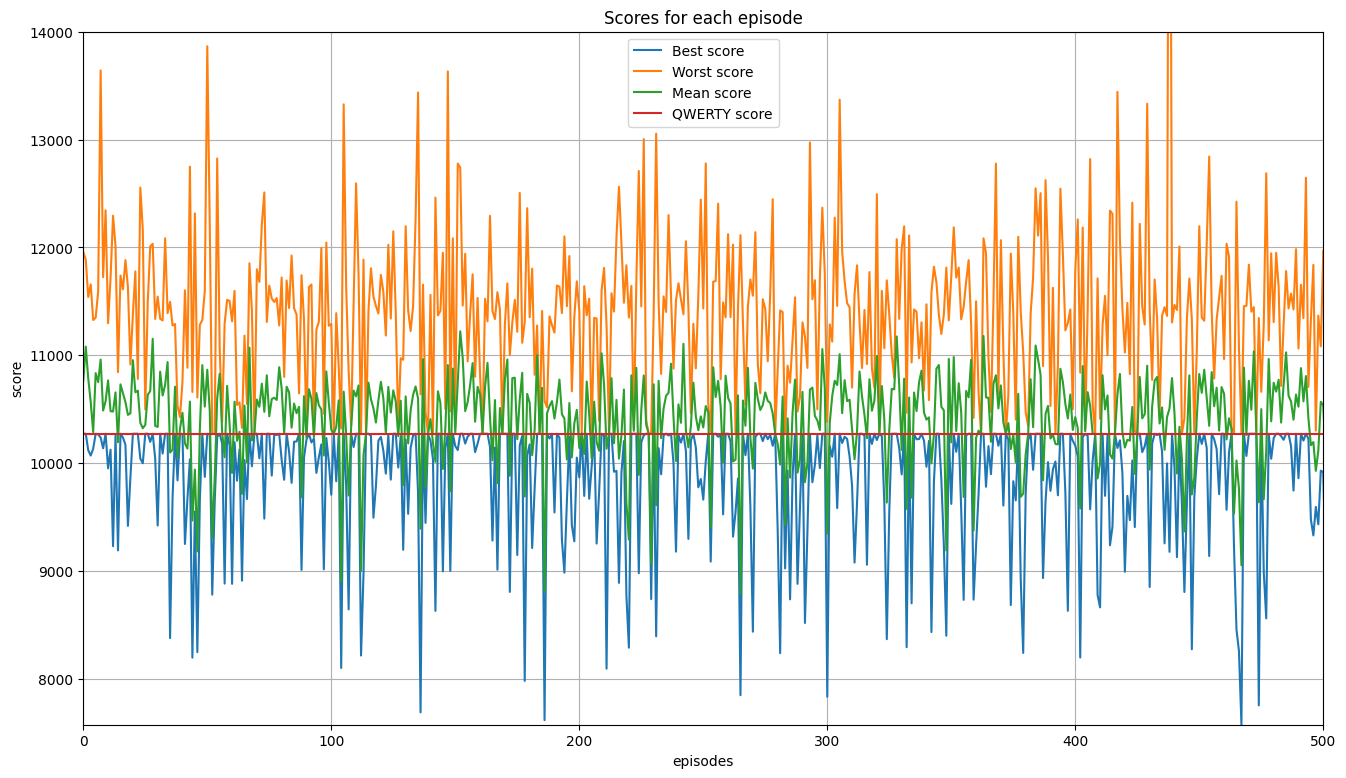

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.plot(best_scores, label="Best score")
plt.plot(worst_scores, label="Worst score")
plt.plot(mean_scores, label="Mean score")
plt.plot(qwerty_scores, label="QWERTY score")

plt.legend()
plt.grid()
plt.xlim([0, 500])
plt.ylim([best_score, 14000])
plt.ylabel("score")
plt.xlabel("episodes")
plt.title("Scores for each episode")
plt.show()